In [ ]:
# load the dataset into mysql using jupyter

In [ ]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('geolocation.csv', 'orders'),
    ('order_items.csv', 'sales'),
    ('orders.csv', 'products'),
    ('payments.csv', 'payments'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products')  # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='your_host',
    user='root',
    password='Prasanthi@10',
    database='target'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'Documents/SQL+Python'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

In [ ]:
# establish the connection for data analysis 

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import mysql.connector 

db = mysql.connector.connect(host = 'localhost',
                             username = 'root',
                             password = 'Prasanthi@10',
                              database = 'target')

cur = db.cursor()

# List all unique cities where customers are located.

In [3]:
query = """ select distinct(customer_city) from customers """
cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data, columns = ['customer_city'])
df.head()

,customer_city
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017 

In [4]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017"""
cur.execute(query)
data = cur.fetchall()
'total orders placed in 2017 are', data[0][0]

('total orders placed in 2017 are', 45101)

# Find total sales per category 

In [6]:
query = """ select products.product_category category, sum(payments.payment_value)
from products join order_items on products.product_id = order_items.product_id 
join payments  on payments.order_id = order_items.order_id 
group by category 
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["category", "sales"])
df

,category,sales
0,perfumery,5.067387e+05
1,Furniture Decoration,1.430176e+06
2,telephony,4.868821e+05
3,bed table bath,1.712554e+06
4,automotive,8.522943e+05
...,...,...
69,cds music dvds,1.199430e+03
70,La Cuisine,2.913530e+03
71,Fashion Children's Clothing,7.856700e+02
72,PC Gamer,2.174430e+03


# Calculate the percentage of orders that were paid in installments 

In [5]:
query = """ select sum(case when payment_installments >=1 then 1 else 0 end)/count(*)*100
            from payments"""

cur.execute(query)
data = cur.fetchall()
data

[(Decimal('100.0000'),)]

# Count the number of customers from each state

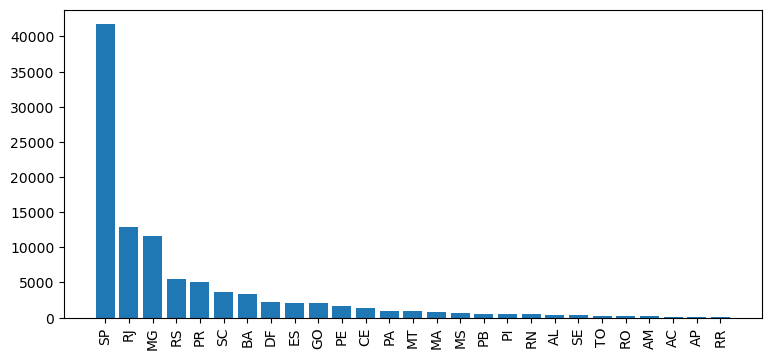

In [8]:
query = """ select customer_state, count(customer_id) from customers 
            group by customer_state"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['state', 'customer_count'])
df = df.sort_values(by = 'customer_count', ascending = False)

plt.figure(figsize=(9,4))
plt.bar(df['state'], df['customer_count'])
plt.xticks(rotation = 90)
plt.show()

# Calculate the number of orders per month in 2018

In [22]:
query = """ select month(order_purchase_timestamp) months, count(order_id) orders from orders where
            year(order_purchase_timestamp) = 2018 
            group by months"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['months', 'order_count'])
df

,months,order_count
0,7,6292
1,8,6512
2,2,6728
3,6,6167
4,3,7211
5,1,7269
6,5,6873
7,4,6939
8,9,16
9,10,4


# Find the average number of products per order, grouped by customer city.

In [24]:
query = """with count_per_order as (select orders.order_id, orders.customer_id, 
            count(order_items.order_id) as oc
            from orders join order_items
            on orders.order_id = order_items.order_id
            group by orders.order_id, orders.customer_id)

            select customers.customer_city, round(avg(count_per_order.oc),2) from customers join
            count_per_order on customers.customer_id = count_per_order.customer_id
            group by customers.customer_city
            """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['customer_city', 'average order'])
df.head(10)

,customer_city,average order
0,sao paulo,1.16
1,sao jose dos campos,1.14
2,porto alegre,1.17
3,indaial,1.12
4,treze tilias,1.27
5,rio de janeiro,1.15
6,mario campos,1.33
7,guariba,1.00
8,cuiaba,1.20
9,franca,1.25


# Calculate the percentage of total revenue contributed by each product categry

In [27]:
query = """ select upper(products.product_category) category, 
            round(sum(payments.payment_value),2)/ (select sum(payment_value) from payments)*100 sales
            from products join order_items on products.product_id = order_items.product_id 
            join payments  on payments.order_id = order_items.order_id 
            group by category order by sales desc
        """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Category', 'percentage_distribution'])
df

,Category,percentage_distribution
0,BED TABLE BATH,10.697529
1,HEALTH BEAUTY,10.352841
2,COMPUTER ACCESSORIES,9.902824
3,FURNITURE DECORATION,8.933649
4,WATCHES PRESENT,8.927654
...,...,...
69,PC GAMER,0.013583
70,HOUSE COMFORT 2,0.010685
71,CDS MUSIC DVDS,0.007492
72,FASHION CHILDREN'S CLOTHING,0.004908


# Identify the correlation between product price and the number of times a priduct has ben purchased. 

In [62]:
query =  """ select products.product_category,
            count(order_items.product_id), round(avg(order_items.price),2)
            from products join order_items 
            on products.product_id = order_items.product_id 
            group by products.product_category """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Category', 'order_count', 'price'])

arr1 = df['order_count']
arr2 = df['price']
np.corrcoef([arr1, arr2])

array([[ 1.        , -0.10631514],
       [-0.10631514,  1.        ]])

# Calculate the total revenue generated by each seller, and rank them by revenue

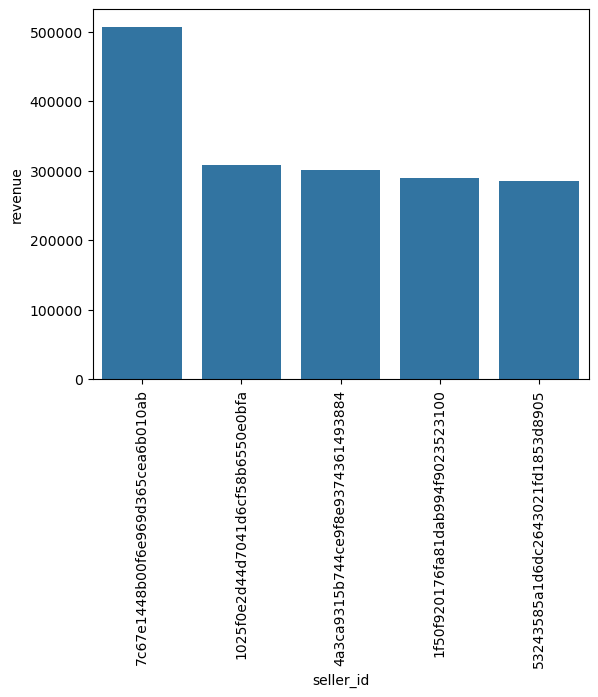

In [12]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from
            (select order_items.seller_id, sum(payments.payment_value) revenue
            from order_items join payments on 
            order_items.order_id = payments.order_id 
            group by order_items.seller_id) as a """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['seller_id', 'revenue', 'rank'])
df = df.head()
sns.barplot(x = 'seller_id', y = 'revenue', data = df)
plt.xticks(rotation=90)
plt.show()

# Calculate the moving average of order values for each customer over their order history

In [20]:
query = """ select customer_id, order_purchase_timestamp, payment, 
            avg(payment) over(partition by customer_id order by order_purchase_timestamp
            rows between 2 preceding and current row) as mov_avg
            from
            (select orders.customer_id, orders.order_purchase_timestamp, 
            payments.payment_value as payment
            from payments join orders 
            on payments.order_id = orders.order_id) as a """

cur.execute(query)
data = cur.fetchall()
data 

df = pd.DataFrame(data, columns = ['customer_id', 'order_purchase_timestamp', 'payment', 'mov_avg'])
df

,customer_id,order_purchase_timestamp,payment,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,0.64,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


# Calculate the cummulative sales per month for each year.

In [23]:
query = """ select years, months, sum(payment) 
            over(order by years, months) cummulative_sales from 
            (select year(order_purchase_timestamp) as years, month(orders.order_purchase_timestamp) as months, 
            round(sum(payments.payment_value),2) as payment from orders join payments
            on orders.order_id = payments.order_id
            group by years, months order by years, months) as a  """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['year', 'month', 'payment_value'])
df

,year,month,payment_value
0,2016,9,252.24
1,2016,10,59342.72
2,2016,12,59362.34
3,2017,1,197850.38
4,2017,2,489758.39
5,2017,3,939621.99
6,2017,4,1357410.02
7,2017,5,1950328.84
8,2017,6,2461605.22
9,2017,7,3053988.14


# Calculate the year-over-year growth rate of total sales

In [43]:
query = """ with a as(select year(orders.order_purchase_timestamp) as years, 
            round(sum(payments.payment_value),2) as payment from orders join payments
            on orders.order_id = payments.order_id
            group by years order by years) 

            select years, ((payment - lag(payment,1) over(order by years))/lag(payment, 1) over(order by years)) * 100 from a
            
            """

# (current sales - previous year sales / previous year sales)*100 to get a percentage 

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data, columns = ['years', 'yoy%growth'])
df

,years,yoy%growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924
